# Transfer Learning (Visual Transformers)

In our [previous experiment](./03-efficientnet.ipynb), we successfully used transfer learning to push our accuracy to a remarkable 92%. We *borrowed* the "eyes" of a model trained on a massive dataset and taught it to see our specific CIFAR-10 classes. But what if we could teach a machine to look at an image less like a grid of pixels and more like... a sentence?

This is where the **vision transformer** architecture comes in. 

It represents a radical shift from the convolutional approach we've used so far. Instead of sliding small filters across an image to find local patterns, ViT breaks an image into a series of patches and treats them like words in a sequence. Then, it applies the same powerful self-attention mechanism to understand the relationships between different parts of the image, no matter how far apart they are.

## Data Preparation

We are going to use the same CIFAR-10 dataset, but this time, to make the training faster on this much larger model, we'll only use a 35% subset of the training data. Let's see if a more powerful model can achieve more with less data.

In [1]:
from datasets import load_dataset
train, test = load_dataset('uoft-cs/cifar10', split=['train[:35%]', 'test'])
class_names = train.features['label'].names
print(f'Training samples: {len(train)}')

Training samples: 17500


Just like in our [previous attempt](./03-efficientnet.ipynb), we must preprocess our data first. But unlike a CNN, a transformer, born to process text, doesn't think in terms of pixels. It thinks in terms of tokens in a sequence. 

So how do we make an image look like a sentence?

The answer is to slice it! The vision transformer preprocessor breaks the input image into a grid of fixed-size patches (e.g., 16x16 pixels), and then treats them as a sequence of patches. This sequence of patches is what the model actually "reads". To handle this requirement, we must use the specific image processor that comes with the desired model.

In [2]:
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

def process(data):
    processed_data = processor(data['img'], return_tensors='tf')
    return dict(pixel_values=processed_data['pixel_values'], label=data['label'])

Our models are getting bigger and bigger, and so is the data they need. CIFAR10 is still a reasonably sized dataset, but if we try to load and process a really big one, we may easily run out of available system memory.

To solve this, we'll create a more efficient input pipeline. Think of it as a conveyor belt - it takes our raw dataset, pulls out small batches of images, applies our process function on the fly, and feeds these batches directly to the GPU. This is far more efficient and is standard practice for training large models.

In [3]:
train, validation = train.train_test_split(0.2, seed=0).values()

def create_input_pipeline(ds):
    return ds.with_transform(process).to_tf_dataset(
        columns='pixel_values', 
        label_cols='label',
        batch_size=32,
    )

train_data = create_input_pipeline(train)
validation_data = create_input_pipeline(validation)
test_data = create_input_pipeline(test)

## Building and Training the Model

Here's where things get interesting. 

While convoluted neural networks (like VGG or EfficientNet) learn by sliding filters across an image to build up a hierarchy of features (edges, textures, shapes), the vision transformer architecture takes a completely different route.

The key idea behind ViT is the **self-attention** mechanism. 

For every single patch of the image, it weighs the importance of every other patch to understand its context. A patch representing a cat's ear can directly "pay attention" to a patch representing its tail, no matter how far apart they are. This gives the model a powerful, holistic understanding of the *entire* image.

For this experiment, we might use a pre-trained model called `google/vit-base-patch16-224`. The name tells us it's a base-sized model that breaks images into 16x16 patches and was originally trained on 224x224 images.

In [4]:
%env TF_USE_LEGACY_KERAS=1
from transformers import TFViTForImageClassification as ViTForImageClassification
from transformers import logging, set_seed

logging.set_verbosity_error()
set_seed(0)

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(class_names),
    ignore_mismatched_sizes=True
)

env: TF_USE_LEGACY_KERAS=1


By setting `ignore_mismatched_sizes=True`, we tell the model to discard its original classification head (which was trained on a different number of classes) and allow us to attach our own, ready to be trained on CIFAR-10. 

Next, we need an optimization routine. We might borrow one from our previous transformer attempt - that shows how similar those models are despite being used for a completely different task. 

The only change we need to make is to slightly change the training step calculation formula - we might exclude the batch size and validation split from the equation, because we already handled them during our dataset creation.

In [5]:
from transformers import create_optimizer

epochs = 2
num_train_steps = len(train_data) * epochs

optimizer, _ = create_optimizer(
    init_lr=0.00002,
    weight_decay_rate=0.01,
    num_warmup_steps=int(num_train_steps * 0.1),
    num_train_steps=num_train_steps
)

We may train our model now.

In [6]:
from tensorflow import device
with device('/GPU'):
    model.compile(optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(train_data, epochs=epochs, validation_data=validation_data)

Epoch 1/2
438/438 [==============================] - 1310s 3s/step - loss: 0.5451 - accuracy: 0.8607 - val_loss: 0.0914 - val_accuracy: 0.9791
Epoch 2/2
438/438 [==============================] - 1305s 3s/step - loss: 0.0477 - accuracy: 0.9914 - val_loss: 0.0622 - val_accuracy: 0.9843


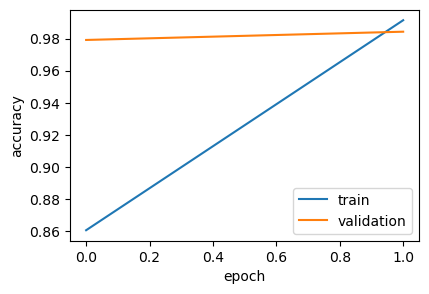

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4.5, 3))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

## Result

In [8]:
import numpy as np
from sklearn.metrics import classification_report
with device('/GPU'):
    y_pred_logits = model.predict(test_data).logits
    y_pred_labels = np.argmax(y_pred_logits, axis=1)
    y_true_labels = [example['label'] for example in test]
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

313/313 [==============================] - 270s 854ms/step
              precision    recall  f1-score   support

    airplane       0.98      0.98      0.98      1000
  automobile       0.98      0.98      0.98      1000
        bird       0.99      0.98      0.99      1000
         cat       0.95      0.95      0.95      1000
        deer       0.98      0.98      0.98      1000
         dog       0.96      0.96      0.96      1000
        frog       0.99      0.99      0.99      1000
       horse       0.99      0.99      0.99      1000
        ship       0.98      0.99      0.99      1000
       truck       0.97      0.97      0.97      1000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



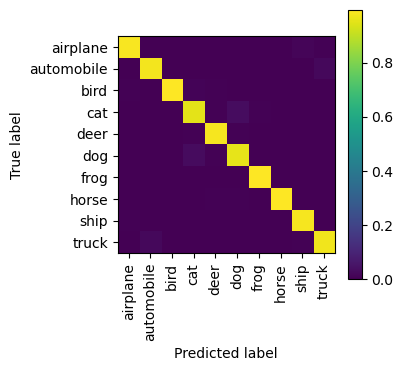

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
ConfusionMatrixDisplay.from_predictions(
    y_true_labels, 
    y_pred_labels, 
    display_labels=class_names, 
    normalize='pred',
    xticks_rotation='vertical',
    include_values=False, 
    ax=ax
)

## Conclusion

The result is nothing short of incredible - after just two epochs of tuning on a *subset* of the data, we've achieved a stunning **98%** accuracy. This is a massive leap, and it powerfully demonstrates the power of modern transformer archirectures.

The training curves are also beautiful, showing rapid learning and near-perfect convergence between training and validation sets, indicating a model that generalises data very well.

This journey — from a simple CNN struggling with a moderate accuracy to a fine-tuned transformer reaching near-human performance — showcases the incredible progress in computer vision. It clearly shows us that often the biggest gains come not just from tuning, but from the complete paradigm shift - to the one that fundamentally *thinks* about the problem in a much more effective way.